In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import logging
import functools
import pathlib
import numpy as np
import pandas as pd

#import clue

handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
# clue.logger.addHandler(handler)
# clue.logger.setLevel(logging.DEBUG)

data = pathlib.Path('./data')
output_dir = pathlib.Path('/data/goodwintrr/data/clue_v1.3')
output_dir.mkdir(parents=False, exist_ok=True)

single_task_output_dir = output_dir
# single_task_output_dir.mkdir(parents=False, exist_ok=True)

multi_task_output_dir = output_dir
# multi_task_output_dir.mkdir(parents=False, exist_ok=True)

In [50]:
 odf: pd.DataFrame = pd.read_csv('/data/LHC_mimic/mimic3_1.4/raw_data/NOTEEVENTS.csv',
                                parse_dates=["CHARTDATE"],
                                usecols=['SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'ISERROR', 'CATEGORY', 'TEXT'],
                                dtype={
                                    "SUBJECT_ID": np.uint64,
                                    "HADM_ID": pd.Int64Dtype(),
                                    "TEXT": np.str,
                                    "ISERROR": np.str,
                                })



# Save
#df.to_csv(data / 'records.text.csv', header=False, index=False)

In [51]:
odf

,SUBJECT_ID,HADM_ID,CHARTDATE,CATEGORY,ISERROR,TEXT
0,22532,167853,2151-08-04,Discharge summary,NaN,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527,2118-06-14,Discharge summary,NaN,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118,2119-05-25,Discharge summary,NaN,Admission Date: [**2119-5-4**] D...
3,13702,196489,2124-08-18,Discharge summary,NaN,Admission Date: [**2124-7-21**] ...
4,26880,135453,2162-03-25,Discharge summary,NaN,Admission Date: [**2162-3-3**] D...
...,...,...,...,...,...,...
2083175,31097,115637,2132-01-21,Nursing/other,NaN,NPN\n\n\n#1 Infant remains in RA with O2 sats...
2083176,31097,115637,2132-01-21,Nursing/other,NaN,"Neonatology\nDOL #5, CGA 36 weeks.\n\nCVR: Con..."
2083177,31097,115637,2132-01-21,Nursing/other,NaN,Family Meeting Note\nFamily meeting held with ...
2083178,31097,115637,2132-01-21,Nursing/other,NaN,NPN 1800\n\n\n#1 Resp: [**Known lastname 2243*...


In [52]:
# Drop error notes
df = odf[odf.ISERROR != '1'].drop(columns=['ISERROR']).dropna()
df = df.astype({'HADM_ID': np.uint64})
df.to_csv(data / 'records.text.csv', header=False, index=False)

In [20]:
dir2 = pathlib.Path('/data/goodwintrr/data/clue_v1.2')
dir3 = pathlib.Path('/data/goodwintrr/data/clue_v1.3')

dir3.mkdir(exist_ok=True)

for file in dir2.glob('*.csv'):
    print(file)
    df = pd.read_csv(file)
    try:
        df = df.drop(columns=['observations'])
    except KeyError:
        continue
    df.to_csv(dir3 / file.name, index=False)
    

/data/goodwintrr/data/clue_v1.2/staging_pi.all.csv
/data/goodwintrr/data/clue_v1.2/phenotyping.test.csv
/data/goodwintrr/data/clue_v1.2/mortality.train.csv
/data/goodwintrr/data/clue_v1.2/staging_anemia.valid.csv
/data/goodwintrr/data/clue_v1.2/phenotyping.all.csv
/data/goodwintrr/data/clue_v1.2/mortality.test.csv
/data/goodwintrr/data/clue_v1.2/length_of_stay.calib.csv
/data/goodwintrr/data/clue_v1.2/staging_pi.valid.csv
/data/goodwintrr/data/clue_v1.2/staging_aki.all.csv
/data/goodwintrr/data/clue_v1.2/staging_anemia.test.csv
/data/goodwintrr/data/clue_v1.2/length_of_stay.all.csv
/data/goodwintrr/data/clue_v1.2/staging_anemia.train.csv
/data/goodwintrr/data/clue_v1.2/staging_aki.test.csv
/data/goodwintrr/data/clue_v1.2/staging_anemia.all.csv
/data/goodwintrr/data/clue_v1.2/staging_aki.train.csv
/data/goodwintrr/data/clue_v1.2/length_of_stay.test.csv
/data/goodwintrr/data/clue_v1.2/multitask.train.csv
/data/goodwintrr/data/clue_v1.2/staging_pi.train.csv
/data/goodwintrr/data/clue_v1.2

In [7]:
!ls dir2

ls: cannot access dir2: No such file or directory


In [5]:
chronos = clue.load_chronologies(data / 'chronologies.words.csv')

In [6]:
clue.merge_ordinal(chronos, data / 'anemia_severities.csv').to_csv(output_dir / 'staging_anemia.all.csv')
clue.merge_ordinal(chronos, data / 'pi_stages.csv').to_csv(output_dir / 'staging_pi.all.csv')
clue.merge_ordinal(chronos, data / 'aki_stages.csv').to_csv(output_dir / 'staging_aki.all.csv')

In [7]:
# 24-, 48-, and 72-hour mortality
mortality_labels = [('%dh' % n, np.timedelta64(n, 'h')) for n in [24, 48, 72]]
# 30-, 60-, and 90-day mortality
mortality_labels += [('%dd' % n, np.timedelta64(n, 'D')) for n in [10, 30, 90]]
# 1-year mortality
mortality_labels.append(('1y', np.timedelta64(1, 'Y')))

clue.merge_time_buckets(chronos, data / 'expire_times.csv', 'deathtime', mortality_labels).to_csv(output_dir / 'mortality.all.csv')

In [8]:
# Buckets for < 24h, and each day in a week
los_labels = [('<%dd' % n, np.timedelta64(n + 1, 'D')) for n in [1, 2, 3, 4, 5, 6, 7, 8]]
# Bucket for < 2 weeks
los_labels.append(('<2w', np.timedelta64(2, 'W')))
    
clue.merge_time_buckets(chronos, data / 'discharge_times.csv', 'dischtime', los_labels).to_csv(output_dir / 'length_of_stay.all.csv')

In [9]:
clue.merge_phenotypes(chronos, data / 'benchmark_ccs_phenotypes.csv').to_csv(output_dir / 'phenotyping.all.csv')

In [4]:
hadms = clue.load_hadms(data / 'hadms.csv')

In [5]:
govf_threshold = 0.9
_, age_buckets = clue.find_optimal_buckets(hadms, "adjusted_age", govf_threshold)
print('Determined (adjusted) age buckets as:', age_buckets)
_, oasis_buckets = clue.find_optimal_buckets(hadms, "adjusted_oasis", govf_threshold)
print('Determined (adjusted) oasis buckets as:', oasis_buckets)

Determined (adjusted) age buckets as: [15.049966, 41.51677, 59.81109, 75.68788, 90.0]
Determined (adjusted) oasis buckets as: [0.0, 10.0, 25.0, 36.0, 68.0]


In [6]:
buckets = {
    'adjusted_age': clue.BucketMapping([0] + age_buckets[1:-1] + [99]),
    'gender': clue.CategoryMapping(['F', 'M']),
    'icu': clue.CategoryMapping(['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU', 'NICU']),
    'adjusted_oasis': clue.BucketMapping([0] + oasis_buckets[1:-1] + [999]),
    'ethnicity': clue.CategoryMapping(['ASIAN', 'BLACK', 'HISPANIC/LATINO', 'OTHER', 'UNKNOWN', 'WHITE']),
    'insurance': clue.CategoryMapping(['Government', 'Medicaid', 'Medicare', 'Private', 'Self Pay']),
    'admission_type': clue.CategoryMapping(['ELECTIVE', 'EMERGENCY', 'URGENT']),
    'admission_location': clue.CategoryMapping(['CLINIC REFERRAL', 'OTHER', 'PHYS REFERRAL', 'TRANSFER FROM HOSP'])
}

splitter = clue.NamedStratifier({'train': 7,
                                 'test': 1,
                                 'valid': 1,
                                 'calib': 1})

stratify = functools.partial(clue.stratify, hadms=hadms, splitter=splitter)

In [ ]:
%%time

mortality_labels =  ['24h', '48h', '72h', '10d', '30d', '90d', '1y']
mortality_buckets = {label: clue.BooleanMapping() for label in mortality_labels}

for split, df in stratify(output_dir / 'mortality.all.csv', {**buckets, **mortality_buckets}):
    df.to_csv(output_dir / f'mortality.{split}.csv')

In [7]:
%%time

los_labels = ['<%dd' % n for n in [1, 2, 3, 4, 5, 6, 7, 8]] + ['<2w']
los_buckets = {label: clue.BooleanMapping() for label in los_labels}

for split, df in stratify(output_dir / 'length_of_stay.all.csv', {**buckets, **los_buckets}):
    df.to_csv(output_dir / f'length_of_stay.{split}.csv')

CPU times: user 35min 4s, sys: 3.5 s, total: 35min 8s
Wall time: 35min 16s


In [8]:
%%time

phenotype_labels = [2, 49, 50, 53, 55, 98, 99, 100, 101, 105, 106, 108, 109, 122, 127, 130, 131, 133, 134, 151, 153, 157, 158, 238, 249]
phenotype_buckets = {str(label): clue.BooleanMapping() for label in phenotype_labels}

for split, df in stratify(output_dir / 'phenotyping.all.csv', {**buckets, **phenotype_buckets}):
    df.to_csv(output_dir / f'phenotyping.{split}.csv')

CPU times: user 10min 14s, sys: 2.58 s, total: 10min 16s
Wall time: 10min 19s


In [11]:
%%time

cohorts = { 'aki': clue.BucketMapping([0, 1, 2, 3, 4]),
            'anemia': clue.BucketMapping([0, 1, 2, 3, 4]),
            'pi': clue.BucketMapping([0, 1, 2, 3, 4, 5]) }

for cohort, bucket in cohorts.items():
    logging.info('Creating %s decompensation data', cohort)
    for split, df in stratify(output_dir / f'staging_{cohort}.all.csv', {**buckets, 'label': bucket}):
        df.to_csv(output_dir / f'staging_{cohort}.{split}.csv')

CPU times: user 22min 55s, sys: 5.26 s, total: 23min 1s
Wall time: 23min 6s


In [10]:
%%time

import typing
import pandas as pd
import numpy as np


def load_labels(label_file: typing.Union[str, pathlib.Path, typing.IO[typing.AnyStr]], 
                observations:bool = True,
                rename: typing.Optional[typing.Mapping[str, str]] = None):
    
    if not observations:
        def usecols(column):
            return column != 'observations'
    else:
        usecols = None
        
    labels = pd.read_csv(label_file,
                         parse_dates=['timestamp'],
                         dtype={
                             "hadm_id": np.int64,
                         },
                         index_col=['hadm_id', 'timestamp'],
                         usecols=usecols)
    
    if rename is not None:
        labels = labels.rename(columns=rename)
        
    return labels

aki_labels = load_labels(output_dir / f'staging_aki.all.csv', rename={'label': 'aki'})
pi_labels = load_labels(output_dir / f'staging_pi.all.csv', observations=False, rename={'label': 'pi'})
anemia_labels = load_labels(output_dir / f'staging_anemia.all.csv', observations=False, rename={'label': 'anemia'})
phenotype_labels = load_labels(output_dir / 'phenotyping.all.csv', observations=False)
mortality_labels = load_labels(output_dir / 'mortality.all.csv', observations=False)
los_labels = load_labels(output_dir / 'length_of_stay.all.csv', observations=False)

labels = aki_labels
labels = labels.join(pi_labels, how='inner')
labels = labels.join(anemia_labels, how='inner')
labels = labels.join(phenotype_labels, how='inner')
labels = labels.join(mortality_labels, how='inner')
labels = labels.join(los_labels, how='inner')

labels = labels.reset_index(1)

cohorts = { 'aki': clue.BucketMapping([0, 1, 2, 3, 4]),
            'anemia': clue.BucketMapping([0, 1, 2, 3, 4]),
            'pi': clue.BucketMapping([0, 1, 2, 3, 4, 5]) }
phenotype_labels = [2, 49, 50, 53, 55, 98, 99, 100, 101, 105, 106, 108, 109, 122, 127, 130, 131, 133, 134, 151, 153, 157, 158, 238, 249]
phenotype_buckets = {str(label): clue.BooleanMapping() for label in phenotype_labels}
mortality_labels =  ['24h', '48h', '72h', '10d', '30d', '90d', '1y']
mortality_buckets = {label: clue.BooleanMapping() for label in mortality_labels}
los_labels = ['<%dd' % n for n in [1, 2, 3, 4, 5, 6, 7, 8]] + ['<2w']
los_buckets = {label: clue.BooleanMapping() for label in los_labels}

multitask_buckets = {
    **buckets,
    **cohorts,
    **phenotype_buckets,
    **mortality_buckets,
    **los_buckets,
}

for split, df in stratify(labels, multitask_buckets):
    df.to_csv(output_dir / f'multitask.{split}.csv')

CPU times: user 49min 20s, sys: 7.72 s, total: 49min 28s
Wall time: 49min 38s


In [13]:
%%time

labels = labels.reset_index(1)
for split, df in stratify(labels, multitask_buckets):
    df.to_csv(multi_task_output_dir / f'{split}.csv')

Created split "train" (#1) with 70.13% of the data (target= 0.70%)
Created split "train" (#1) with 70.13% of the data (target= 0.70%)
Dropping 5 admissions with no corresponding labels in split "train"
Dropping 5 admissions with no corresponding labels in split "train"
Created split "test" (#2) with  9.95% of the data (target= 0.10%)
Created split "test" (#2) with  9.95% of the data (target= 0.10%)
Created split "valid" (#3) with  9.91% of the data (target= 0.10%)
Created split "valid" (#3) with  9.91% of the data (target= 0.10%)
Dropping 1 admissions with no corresponding labels in split "valid"
Dropping 1 admissions with no corresponding labels in split "valid"
Created split "calib" (#4) with 10.02% of the data (target= 0.10%)
Created split "calib" (#4) with 10.02% of the data (target= 0.10%)
Dropping 1 admissions with no corresponding labels in split "calib"
Dropping 1 admissions with no corresponding labels in split "calib"


CPU times: user 51min 46s, sys: 6.01 s, total: 51min 52s
Wall time: 51min 56s


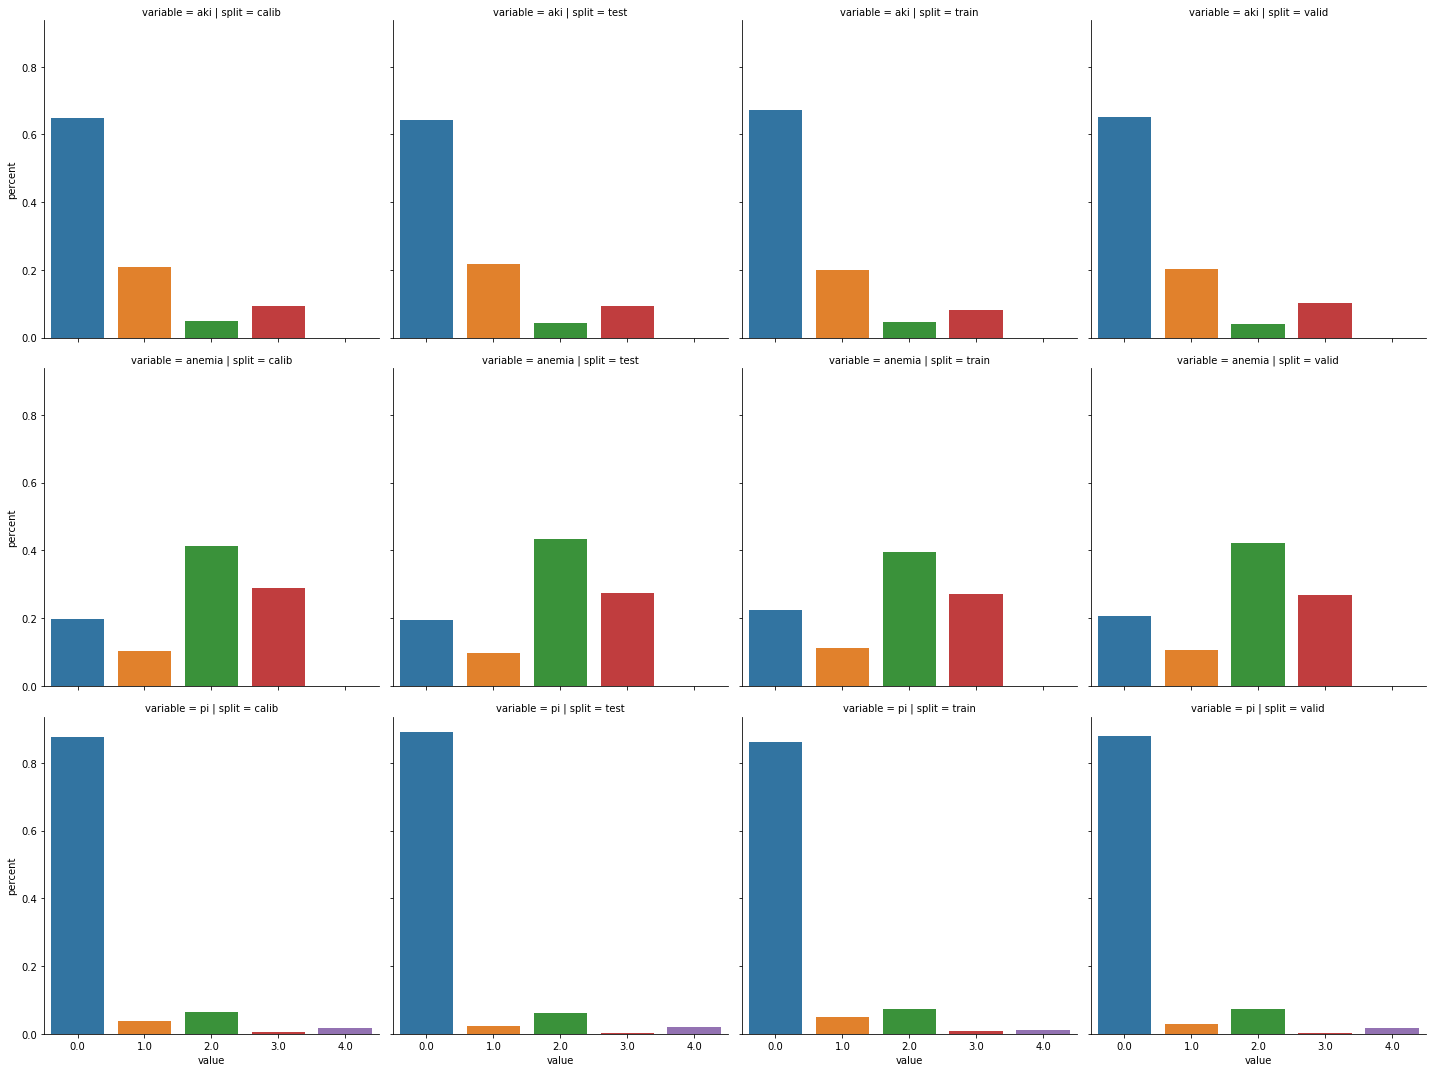

In [32]:
import seaborn as sns

def plot(filename, splits=['train', 'valid', 'calib', 'test']):
    split_dfs = []
    for split in splits:
        split_file = filename / f'{split}.csv'
        split_df = pd.read_csv(split_file, parse_dates=["timestamp"], index_col=['hadm_id', 'timestamp'])
        split_df = split_df.drop(['observations'], axis=1)
        split_df['split'] = split
        split_dfs.append(split_df)
    df = pd.concat(split_dfs)
    
    # Plot decompensation
    tm = df[['split', 'aki', 'anemia', 'pi']].melt(id_vars=['split'])
    tm['count'] = 1
    tc = tm.groupby(['split', 'variable', 'value']).count().reset_index()
    tcg = tc.groupby(['split', 'variable'])['count'].sum().reset_index()
    tc2 = tc.merge(tcg, on=['split', 'variable'])
    tc2['percent'] = tc2['count_x'] / tc2['count_y']
    tc = tc2
    
    return sns.catplot(data=tc[tc['variable'] != 'los'], row='variable', x='value', y='percent', col='split', kind='bar')

plot(multi_task_output_dir)

In [33]:
df

,timestamp,observations,aki,pi,anemia,100,101,105,106,108,...,1y,<1d,<2d,<3d,<4d,<5d,<6d,<7d,<8d,<2w
hadm_id,,,,,,,,,,,,,,,,,,,,,
108845,2188-09-11,C0011847 C3812382 C0012634 C0817096 C0034571 C...,0.0,0.0,2.0,0,1,0,0,0,...,False,True,True,True,True,True,True,True,True,True
108845,2188-08-27,C1963179 C0231303 C0205359 C0234422 C0239110 C...,0.0,0.0,2.0,0,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False
108845,2188-08-26,C3812382 C3714787 C0566415 C0032285 C1709157 C...,0.0,0.0,2.0,0,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False
108845,2188-08-25,C3812382 C0012634 C0205161 C3842377 C1962945 C...,0.0,0.0,0.0,0,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False
108845,2188-09-12,C0597277 C0011847 C0543467 C0079744 C0344232 C...,0.0,0.0,2.0,0,1,0,0,0,...,False,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146717,2110-07-28,C0429103 C0470187 C0039231 C3827868 C0700287 C...,0.0,0.0,0.0,0,0,0,0,0,...,False,False,True,True,True,True,True,True,True,True
146717,2110-07-29,C4281991 C3812382 C0230165 C1709157 C0114346 C...,0.0,0.0,0.0,0,0,0,0,0,...,False,True,True,True,True,True,True,True,True,True
186521,2110-04-25,C0597277 C0554756 C3812382 C0543467 C0566415 C...,0.0,0.0,0.0,0,0,0,0,0,...,True,True,True,True,True,True,True,True,True,True
